<a href="https://colab.research.google.com/github/sayakpaul/SimCLR-in-TensorFlow-2/blob/master/Supervised_Full_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.2


In [2]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
#from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [3]:
# Train and test image paths
train_images = list(paths.list_images("/home/priyanka-s1/Desktop/Projects/SelfSupervisedLearning/SimCLR-in-TensorFlow-2-master/DATASET/full_train/"))
test_images = list(paths.list_images("/home/priyanka-s1/Desktop/Projects/SelfSupervisedLearning/SimCLR-in-TensorFlow-2-master/DATASET/test/"))
print(len(train_images), len(test_images))

2070 230


In [4]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        #print(image_pixels.shape)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[-2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    #print(images.shape, labels.shape)

    return images, labels

In [5]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)

100%|██████████| 230/230 [00:01<00:00, 206.81it/s]


In [6]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [7]:
# Set up TensorFlow dataset for performance optimization

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))
    .shuffle(128)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Utilities

In [8]:
# Architecture utils
def get_resnet():
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    
    inputs = Input((224, 224, 3))
    features = base_model(inputs, training=False)
    pooled_features = GlobalAveragePooling2D()(features)

    pooled_features = Dense(256)(pooled_features)
    pooled_features = Activation("relu")(pooled_features)
    outputs = Dense(23, activation="softmax")(pooled_features)

    resnet_simclr = Model(inputs, outputs)

    return resnet_simclr

In [9]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

## Training

In [10]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

In [11]:
get_resnet().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 23)                5911      
Total params: 24,118,167
Trainable params: 24,065,047
Non-trainable params: 53,120
____________________________________________

Epoch 1/20
65/65 [==============================] - 603s 9s/step - loss: 3.1427 - accuracy: 0.0512 - val_loss: 3.2170 - val_accuracy: 0.0435
Epoch 2/20
65/65 [==============================] - 588s 9s/step - loss: 3.1464 - accuracy: 0.0396 - val_loss: 3.2364 - val_accuracy: 0.0435
Epoch 3/20
65/65 [==============================] - 600s 9s/step - loss: 3.1459 - accuracy: 0.0459 - val_loss: 3.1892 - val_accuracy: 0.0435
Epoch 4/20
65/65 [==============================] - 582s 9s/step - loss: 3.1413 - accuracy: 0.0502 - val_loss: 3.1656 - val_accuracy: 0.0435
Epoch 5/20
65/65 [==============================] - 575s 9s/step - loss: 3.1375 - accuracy: 0.0536 - val_loss: 3.1568 - val_accuracy: 0.0435
Epoch 6/20
65/65 [==============================] - 33660s 526s/step - loss: 3.1255 - accuracy: 0.0570 - val_loss: 3.1444 - val_accuracy: 0.0435
Epoch 7/20
65/65 [==============================] - 576s 9s/step - loss: 3.1286 - accuracy: 0.0502 - val_loss: 3.1624 - val_accuracy: 0.0435
Epoch 8/2

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


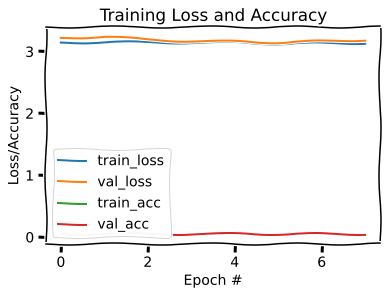

In [12]:
# Train the supervised model with full data

model = get_resnet()
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
              optimizer=tf.keras.optimizers.Adam(1e-3))
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=20,
                    callbacks=[es])
plot_training(history)

In [14]:
score=model.evaluate(X_test, y_test_enc, verbose=0)

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 3.144404411315918
Test accuracy: 0.043478261679410934


In [19]:
res_pred = model.predict(test_ds)

In [20]:
print(len(res_pred))

230
